In [1]:
import numpy as np
from lattice_class import *
import scipy.linalg
import matplotlib.pyplot as plt

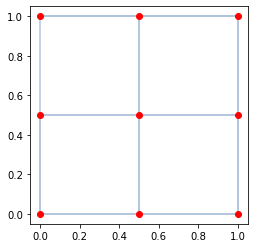

edges =  [[1, 2], [0, 2, 4], [1, 5], [0, 4, 6], [1, 3, 5, 7], [2, 4, 8], [3, 7], [4, 6, 8], [5, 7]]


In [12]:
N = 3
num_sites   = N**2
lattice = SquareLattice(N)

lattice._edges = [[1, 2], [0, 2, 4], [1, 5], [0, 4, 6], [1, 3, 5, 7], [2, 4, 8], [3, 7], [4, 6, 8], [5, 7]]

lattice.plot()

lattice_sites = lattice.get_nodes()
lattice_edges = lattice.get_edges()
reciprocal_lattice_sites = lattice.get_reciprocal_nodes()
k_x_values = [k[0] for k in reciprocal_lattice_sites]
k_y_values = [k[1] for k in reciprocal_lattice_sites]

print("edges = ", lattice_edges)



In [13]:
mu          = -0.5
delta       = complex(0.5, 0.0)

H_k         = lambda k: np.array(
                                [[-(np.cos(k[0]) + np.cos(k[1])) - mu, 0.0], 
                                [0.0, -(np.cos(k[0]) + np.cos(k[1])) - mu]]
                                , dtype=complex)
gap_fct     = lambda k: np.array(
                                [[0.0, delta * complex(np.sin(k[0]), np.sin(k[1]))], 
                                [delta.conjugate() * complex(np.sin(k[0]), -np.sin(k[1])), 0.0]]
                                , dtype=complex)
H_BdG       = lambda k: np.block(
                                [[H_k(k), gap_fct(k)], 
                                [gap_fct(k).conj().T, -H_k(-k).conj()]]
                                )
dim_H_BdG = 4

In [14]:
def get_H_tilde(direction, axis=0):
    H_tilde = np.zeros(shape=(dim_H_BdG, dim_H_BdG), dtype=complex)
    for k in reciprocal_lattice_sites:
        H_tilde += 1.0 / num_sites * H_BdG(np.array(k)) * np.exp(direction * complex(0.0, 1.0) * k[axis])
    return H_tilde



In [15]:
H_direct_lattice = np.zeros(shape=(num_sites * dim_H_BdG, num_sites * dim_H_BdG), dtype=complex)
block_indices = [slice(block_idx * dim_H_BdG, (block_idx+1) * dim_H_BdG) for block_idx in range(lattice.get_num_nodes())]

for (node_idx, node) in enumerate(lattice.get_nodes()):
    H_direct_lattice[block_indices[node_idx], block_indices[node_idx]] = get_H_tilde(0)

    for neighbour_idx in lattice_edges[node_idx]:
        axis = -1 
        if (neighbour_idx) // N != (node_idx // N):
            axis = 1
        elif (neighbour_idx) // N == (node_idx // N):
            axis = 0
        else:
            print("something went terribly wrong while constructing the direct lattice hamiltonian")
        assert axis == 0 or axis == 1, "axis assertion failed"

        direction = 0
        if node_idx < neighbour_idx:
            direction = (-1)**axis
        elif node_idx > neighbour_idx:
            direction = -1 * (-1)** axis
        else:
            print("something went terribly wrong while constructing the direct lattice hamiltonian")
        assert direction == 1 or direction == -1, "direction assertion failed"

        H_direct_lattice[block_indices[node_idx], block_indices[neighbour_idx]] = get_H_tilde(direction, axis)


In [16]:
energies, _ = scipy.linalg.eigh(H_direct_lattice)

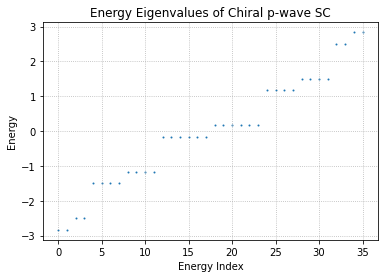

In [17]:
plt.xlabel("Energy Index")
plt.ylabel("Energy")
plt.grid(linestyle=":")
plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=1)